In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, StructType, StructField, TimestampType, IntegerType
from pyspark.sql.functions import from_json, col, avg, sum

# Define the path to the jars on the EC2 instance
spark_jars_path = "/home/ec2-user/stream-processing-template/jars"  # <-- Update this path

spark = SparkSession.builder.appName("retail_pysaprk_consumer") \
    .config("spark.jars", f"{spark_jars_path}/commons-pool2-2.11.1.jar,"
            f"{spark_jars_path}/spark-sql-kafka-0-10_2.12-3.4.0.jar,"
            f"{spark_jars_path}/spark-streaming-kafka-0-10-assembly_2.12-3.4.0.jar") \
    .getOrCreate()


23/12/13 14:04:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
/usr/local/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


In [2]:
# Define the schema for our data
schema = StructType([
    StructField("store_location", StringType(), True),
    StructField("time_of_purchase", TimestampType(), True),
    StructField("product_ID", StringType(), True),
    StructField("transaction_amount", IntegerType(), True)
])

# Stream from Kafka topic
df = spark.readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "b-1.monstercluster1.6xql65.c3.kafka.eu-west-2.amazonaws.com:9092") \
    .option("subscribe", "retail_transactions") \
    .load()

In [3]:
transactions = (df.selectExpr("CAST(value AS STRING)")
                .withColumn("data", from_json(col("value"), schema))
                .select("data.*"))

query = transactions.writeStream \
.format("memory") \
.queryName("temporary_view_one") \
.start()

query.awaitTermination(15)

23/12/13 14:05:13 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-b81e96be-6a35-477a-809c-59cbaaac55ef. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
23/12/13 14:05:13 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
23/12/13 14:05:15 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


False

In [4]:
processed_data = spark.sql("SELECT * FROM temporary_view_one")

In [5]:
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType

transactions = processed_data.withColumn("transaction_amount", col("transaction_amount").cast(DoubleType()))

In [6]:
transactions.count()

23

In [7]:
transactions.show()

+--------------+-------------------+----------+------------------+
|store_location|   time_of_purchase|product_ID|transaction_amount|
+--------------+-------------------+----------+------------------+
|       Houston|2023-12-13 14:05:18|    P00093|             182.0|
|      New York|2023-12-13 14:05:20|    P00009|             792.0|
|   Los Angeles|2023-12-13 14:05:21|    P00033|             635.0|
|   San Antonio|2023-12-13 14:05:22|    P00036|              32.0|
|       Phoenix|2023-12-13 14:05:24|    P00013|             978.0|
|       Houston|2023-12-13 14:05:25|    P00014|             902.0|
|   Los Angeles|2023-12-13 14:05:27|    P00056|             142.0|
|       Houston|2023-12-13 14:05:29|    P00062|             488.0|
|       Chicago|2023-12-13 14:05:31|    P00030|             396.0|
|       Phoenix|2023-12-13 14:05:34|    P00097|             342.0|
|       Chicago|2023-12-13 14:05:35|    P00019|             918.0|
|       Houston|2023-12-13 14:05:38|    P00089|             66

In [8]:
from pyspark.sql.functions import sum
total_transactions = transactions.groupBy("store_location").agg(sum("transaction_amount").alias("total_amount"))
total_transactions.show()

+--------------+------------+
|store_location|total_amount|
+--------------+------------+
|       Phoenix|      3087.0|
|   San Antonio|      1475.0|
|  Philadelphia|      2291.0|
|   Los Angeles|      2225.0|
|       Chicago|      3473.0|
|       Houston|      5020.0|
|      New York|      3185.0|
+--------------+------------+



In [12]:
transaction_counts = transactions.groupBy("store_location").count().withColumnRenamed("count", "transaction_count")
transaction_counts.show()

+--------------+-----------------+
|store_location|transaction_count|
+--------------+-----------------+
|       Phoenix|                7|
|   San Antonio|                8|
|  Philadelphia|               10|
|   Los Angeles|               10|
|       Chicago|               14|
|       Houston|               19|
|      New York|               15|
+--------------+-----------------+



In [11]:
average_transactions = transactions.groupBy("store_location").agg(avg("transaction_amount").alias("average_amount"))
average_transactions.show()

+--------------+-----------------+
|store_location|   average_amount|
+--------------+-----------------+
|       Phoenix|762.2857142857143|
|   San Antonio|          407.875|
|  Philadelphia|            603.6|
|   Los Angeles|            528.3|
|       Chicago|553.6923076923077|
|       Houston|436.1578947368421|
|      New York|525.6666666666666|
+--------------+-----------------+



In [14]:
transactions.dtypes

[('store_location', 'string'),
 ('time_of_purchase', 'timestamp'),
 ('product_ID', 'string'),
 ('transaction_amount', 'double')]

In [17]:
time_series_transactions = (df.selectExpr("CAST(value AS STRING)")
                .withColumn("data", from_json(col("value"), schema))
                .select("data.*"))

query = time_series_transactions.writeStream \
.format("memory") \
.queryName("time_series_view_one") \
.start()

query.awaitTermination(100)

23/12/13 11:55:55 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-9cc2ae08-f5b9-4817-bab0-c9280cfee334. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
23/12/13 11:55:55 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
23/12/13 11:55:56 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


False

In [19]:
time_series_transactions = spark.sql("SELECT * FROM time_series_view_one")
# time_series_transactions = processed_time_series_data.withColumn("transaction_amount", col("transaction_amount").cast(DoubleType()))

In [17]:
from pyspark.sql.functions import hour

transactions_per_hour = transactions.withColumn("purchase_hour", hour("time_of_purchase")).groupby("purchase_hour").count().withColumnRenamed("count", "total_transactions")

transactions_per_hour.show()

+-------------+------------------+
|purchase_hour|total_transactions|
+-------------+------------------+
|           14|               245|
+-------------+------------------+



In [39]:
total_transactions_per_product = transactions.groupBy("product_ID").count().withColumnRenamed("count", "total_transactions")

In [41]:
total_transactions_per_product.orderBy(total_transactions_per_product.total_transactions.desc()).show(5)

+----------+------------------+
|product_ID|total_transactions|
+----------+------------------+
|    P00014|                50|
|    P00075|                49|
|    P00001|                48|
|    P00063|                48|
|    P00006|                47|
+----------+------------------+
only showing top 5 rows



In [43]:
total_amount_per_product = transactions.groupBy("product_ID").agg(sum("transaction_amount").alias("total_amount"))
total_amount_per_product.orderBy(total_amount_per_product.total_amount.desc()).show(5)

+----------+------------+
|product_ID|total_amount|
+----------+------------+
|    P00063|     24805.0|
|    P00057|     23220.0|
|    P00001|     23196.0|
|    P00065|     23083.0|
|    P00028|     22901.0|
+----------+------------+
only showing top 5 rows



### Anomaly Detection
* Identify transactions with amounts significantly different from the average.

In [45]:
from pyspark.sql.functions import avg, col, abs

average_amount = transactions.select(avg("transaction_amount")).first()[0]
average_amount

453.81881086622246

In [50]:
# Set a threshold for significant difference (e.g., 50% more or less than average)
threshold = 0.5 * average_amount
threshold

226.90940543311123

In [51]:
outliers = transactions.filter(abs(col("transaction_amount") - average_amount) > threshold)
outliers.show()

+--------------+-------------------+----------+------------------+
|store_location|   time_of_purchase|product_ID|transaction_amount|
+--------------+-------------------+----------+------------------+
|   San Antonio|2023-12-13 11:43:54|    P00018|             812.0|
|       Chicago|2023-12-13 11:43:56|    P00028|              43.0|
|      New York|2023-12-13 11:44:06|    P00069|             136.0|
|   San Antonio|2023-12-13 11:44:09|    P00014|             787.0|
|       Phoenix|2023-12-13 11:44:13|    P00055|             923.0|
|       Houston|2023-12-13 11:44:15|    P00079|             102.0|
|       Chicago|2023-12-13 11:44:17|    P00063|             141.0|
|       Houston|2023-12-13 11:44:22|    P00089|             919.0|
|   San Antonio|2023-12-13 11:44:36|    P00012|            -317.0|
|      New York|2023-12-13 11:44:40|    P00018|             855.0|
|   San Antonio|2023-12-13 11:44:46|    P00055|             846.0|
|       Houston|2023-12-13 11:44:49|    P00035|             84

In [53]:
from pyspark.sql.functions import col
with_discount = transactions.withColumn("discounted_amount", col("transaction_amount") * 0.9)
with_discount.show()

+--------------+-------------------+----------+------------------+------------------+
|store_location|   time_of_purchase|product_ID|transaction_amount| discounted_amount|
+--------------+-------------------+----------+------------------+------------------+
|       Phoenix|2023-12-13 11:43:53|    P00006|             456.0|410.40000000000003|
|   San Antonio|2023-12-13 11:43:54|    P00018|             812.0| 730.8000000000001|
|       Chicago|2023-12-13 11:43:56|    P00028|              43.0|              38.7|
|       Phoenix|2023-12-13 11:43:57|    P00064|             408.0|             367.2|
|  Philadelphia|2023-12-13 11:44:00|    P00047|             640.0|             576.0|
|   San Antonio|2023-12-13 11:44:03|    P00063|             663.0|             596.7|
|      New York|2023-12-13 11:44:06|    P00069|             136.0|             122.4|
|       Houston|2023-12-13 11:44:07|    P00020|             653.0|             587.7|
|   San Antonio|2023-12-13 11:44:09|    P00014|       

In [60]:
physical_transactions = transactions.filter(transactions.store_location != "online")
physical_transactions.show()

+--------------+-------------------+----------+------------------+
|store_location|   time_of_purchase|product_ID|transaction_amount|
+--------------+-------------------+----------+------------------+
|       Phoenix|2023-12-13 11:43:53|    P00006|             456.0|
|   San Antonio|2023-12-13 11:43:54|    P00018|             812.0|
|       Chicago|2023-12-13 11:43:56|    P00028|              43.0|
|       Phoenix|2023-12-13 11:43:57|    P00064|             408.0|
|  Philadelphia|2023-12-13 11:44:00|    P00047|             640.0|
|   San Antonio|2023-12-13 11:44:03|    P00063|             663.0|
|      New York|2023-12-13 11:44:06|    P00069|             136.0|
|       Houston|2023-12-13 11:44:07|    P00020|             653.0|
|   San Antonio|2023-12-13 11:44:09|    P00014|             787.0|
|   San Antonio|2023-12-13 11:44:11|    P00095|             408.0|
|       Phoenix|2023-12-13 11:44:13|    P00055|             923.0|
|       Houston|2023-12-13 11:44:15|    P00079|             10

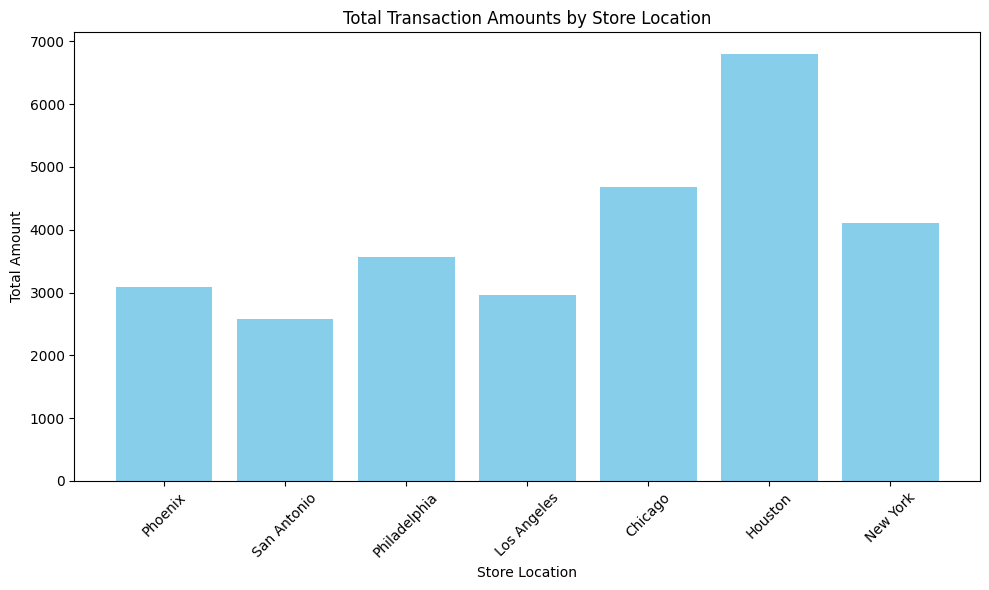

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert to Pandas dataframe
agg_by_location_pd = total_transactions.toPandas()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(agg_by_location_pd['store_location'], agg_by_location_pd['total_amount'], color='skyblue')
plt.title('Total Transaction Amounts by Store Location')
plt.xlabel('Store Location')
plt.ylabel('Total Amount')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

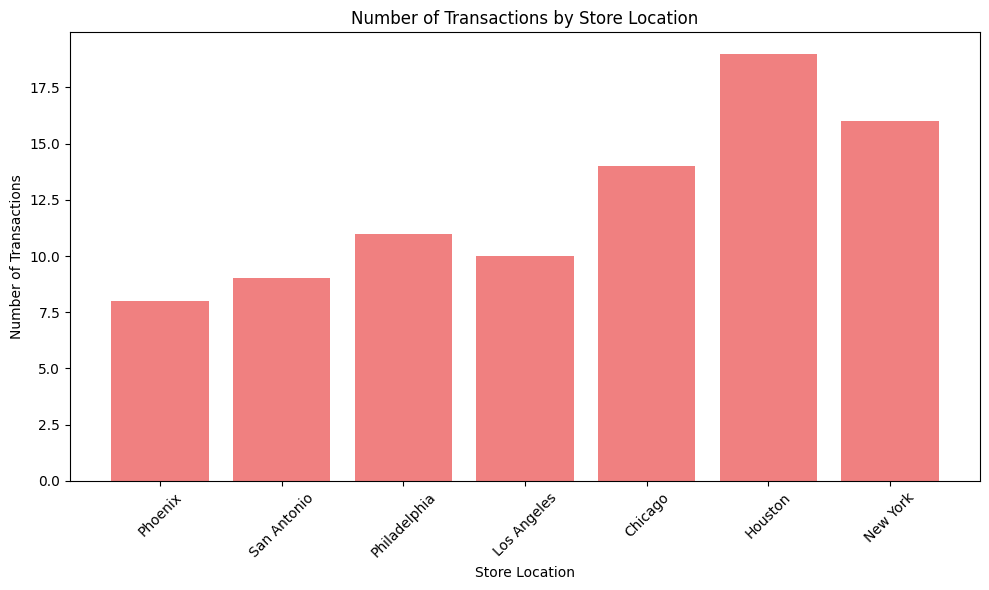

In [14]:
count_by_location_pd = transaction_counts.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(count_by_location_pd['store_location'], count_by_location_pd['transaction_count'], color='lightcoral')
plt.title('Number of Transactions by Store Location')
plt.xlabel('Store Location')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

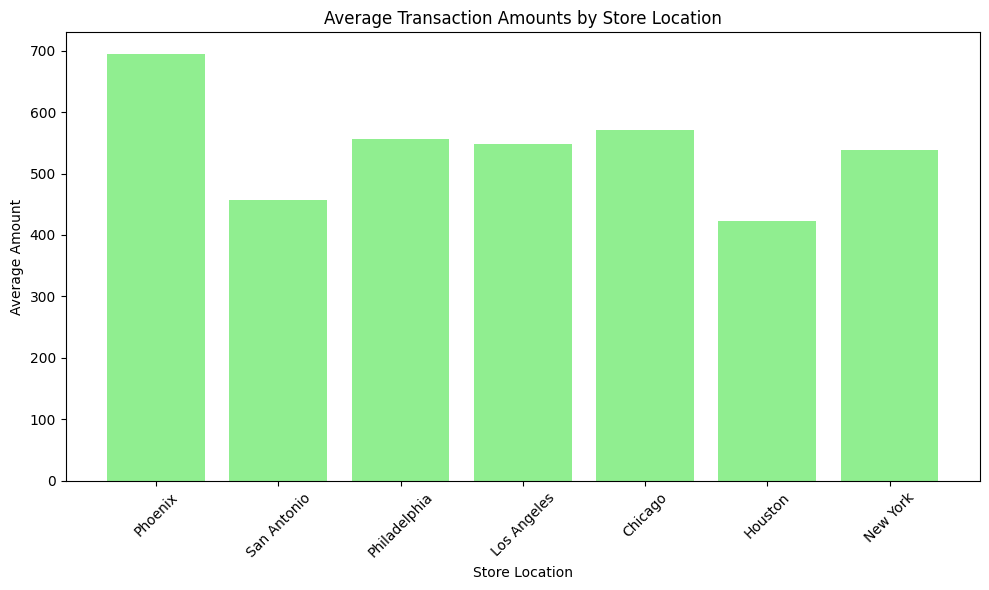

In [15]:
avg_by_location_pd = average_transactions.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(avg_by_location_pd['store_location'], avg_by_location_pd['average_amount'], color='lightgreen')
plt.title('Average Transaction Amounts by Store Location')
plt.xlabel('Store Location')
plt.ylabel('Average Amount')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()